In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

In [3]:
from functions_v2 import(import_folder_dataset,
                         Data,
                         calculate_IoU,
                         plot_loss_accuracy, 
                         save_model,
                         save_metrics,
                         make_predictions)

# 1. Build an image segmentation model using pytorch

In [4]:
# Learning parameters.
epochs = 50 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4

checkpoints_save = 25 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 3/CheckPoints/"

cuda


In [6]:
#PyTorch - Building the Model
class SegmentationNet(nn.Module):
    def __init__(self):
        super(SegmentationNet, self).__init__()
        
        #################################
        ############ Encoder ############
        #################################
        
        '''
        In dimension:              1024 * 1024 * 3 
        Out dimension Conv:        1024 * 1024 * 64
        Out dimension MaxPooling:  512  * 512  * 64
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              512  * 512  * 64
        Out dimension Conv:        512  * 512  * 128
        Out dimension MaxPooling:  256  * 256  * 128
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        #################################
        ############ Decoder ############
        #################################
        
        '''
        In dimension:                 256 * 256 * 128
        Out dimension Conv:           256 * 256 * 64
        Out dimension ConvTranspose:  512 * 512 * 64
        '''
        self.tcnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.convTrans4 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        
        '''
        In dimension:                 512  * 512  * 64
        Out dimension Conv:           512  * 512  * 32
        Out dimension ConvTranspose:  1024 * 1024 * 32
        '''
        self.tcnn5_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.convTrans5 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        ######################################
        ############ Segmentation ############
        ######################################
        
        '''
        In dimension:                 1024 * 1024 * 32
        Out dimension Conv:           1024 * 1024 * 2
        '''
        self.segmentation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(2),
            nn.ReLU()
        )
        
    def forward(self, x): 
        
        #################################
        ############ Encoder ############
        #################################
        #print("Before Cnn1 ",x.shape)
        # Convolution
        x = self.cnn1_model(x)
        #print("Before MaxPool1 ",x.shape)
        # Max pooling
        x = self.maxpool1(x)
        
        #print("Before Cnn2 ",x.shape)
        # Convolution
        x = self.cnn2_model(x)
        #print("Before MaxPool2 ",x.shape)
        # Max pooling
        x = self.maxpool2(x)
        
        #################################
        ############ Decoder ############
        #################################
        
        #print("Before TCnn4 ",x.shape)
        # Convolution
        x = self.tcnn4_model(x)
        #print("Before ConvTransl4 ",x.shape)
        # Transopose Convolution
        x = self.convTrans4(x)
        
        #print("Before TCnn5 ",x.shape)
        # Convolution
        x = self.tcnn5_model(x)
        #print("Before ConvTransl5 ",x.shape)
        # Transopose Convolution
        x = self.convTrans5(x)
        
        ######################################
        ############ Segmentation ############
        ######################################
        
        #print("Before Segmentation ",x.shape)
        # Convolution Segmentation
        x = self.segmentation(x)
        #print("After Segmentation ",x.shape)
        return x

In [7]:
#PyTorch - Visualizing the Model
modelpy = SegmentationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")

# Loss function.
#criterion = nn.BCEWithLogitsLoss() # Set the loss function to BCEWithLogitsLoss
criterion = nn.CrossEntropyLoss()


parameters = filter(lambda p: p.requires_grad, modelpy.parameters())
optim = torch.optim.Adam(parameters, lr=lr)
#optim = torch.optim.SGD(params=parameters, lr=lr, momentum=0.9, weight_decay=1e-5)# , momentum=0.9, weight_decay=0.0005


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0

modelpy

model created


SegmentationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tcnn4_model): 

In [8]:
# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion  = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")



In [9]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 446222


## Load data

In [10]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 3/Data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 3/Data/Test"

img_size = (256, 256) # (1024, 1024)

In [11]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    #transforms.Resize((1024, 1024)),
                                    transforms.Resize(img_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [12]:
train_data, train_mask, train_labels = import_folder_dataset(root_path = train_data_path, resized_side = img_size)#(1024,1024)

print("Dim of Data: ", train_data.shape)
print("Dim of Mask: ", train_mask.shape)
print("Dim of Lables: ", train_labels.shape)

100%|██████████| 800/800 [00:49<00:00, 16.01it/s]


Dim of Data:  (800, 256, 256, 3)
Dim of Mask:  (800, 256, 256, 3)
Dim of Lables:  (800, 256, 256)


In [13]:
# Split into Train, Validation
X_train, X_val, m_train, m_val, y_train, y_val = train_test_split(train_data, train_mask, train_labels, test_size=0.1, random_state=42)
print("Dim of Image Train: ", X_train.shape)
print("Dim of Mask Train: ", m_train.shape)
print("Dim of Lables Train: ", y_train.shape)


print("Dim of Image Validation: ", X_val.shape)
print("Dim of Mask Validation: ", m_val.shape)
print("Dim of Lables Validation: ", y_val.shape)

Dim of Image Train:  (720, 256, 256, 3)
Dim of Mask Train:  (720, 256, 256, 3)
Dim of Lables Train:  (720, 256, 256)
Dim of Image Validation:  (80, 256, 256, 3)
Dim of Mask Validation:  (80, 256, 256, 3)
Dim of Lables Validation:  (80, 256, 256)


In [14]:
# Create the dataset object
train_Dataset = Data(X_train, m_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data(X_val, m_val, y_val, img_transform)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  720
Val len:  80


In [15]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

# 2. Train your model using [lung segmentation datasets](https://github.com/YoushanZhang/Lung_Segmentation)


Epoch 1 of 50


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


train loss:  0.10597340992341439
Val loss:  0.08233839124441147
train IoU:  0.49459231233793416
Val IoU:  0.6393665939569473
Current time: 0.786 minutes. Time expected till completion: 38.490 minutes

Epoch 2 of 50


100%|██████████| 20/20 [00:01<00:00, 11.20it/s]


train loss:  0.059411787158913085
Val loss:  0.047701559215784076
train IoU:  0.7193201318383217
Val IoU:  0.7752192616462708
Current time: 1.443 minutes. Time expected till completion: 34.636 minutes

Epoch 3 of 50


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


train loss:  0.04154775616609388
Val loss:  0.039267596695572136
train IoU:  0.7964818365044064
Val IoU:  0.8092488527297974
Current time: 2.100 minutes. Time expected till completion: 32.908 minutes

Epoch 4 of 50


100%|██████████| 20/20 [00:01<00:00, 11.14it/s]


train loss:  0.0352368703422447
Val loss:  0.033044989220798016
train IoU:  0.8237458517154058
Val IoU:  0.8387087941169739
Current time: 2.758 minutes. Time expected till completion: 31.714 minutes

Epoch 5 of 50


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


train loss:  0.032358062267303464
Val loss:  0.03330195415765047
train IoU:  0.8351188765631782
Val IoU:  0.8352894306182861
Current time: 3.415 minutes. Time expected till completion: 30.737 minutes

Epoch 6 of 50


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


train loss:  0.029583832963059345
Val loss:  0.031422370206564666
train IoU:  0.8477401895655526
Val IoU:  0.8422056823968888
Current time: 4.073 minutes. Time expected till completion: 29.866 minutes

Epoch 7 of 50


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


train loss:  0.028900972722719114
Val loss:  0.038138216454535724
train IoU:  0.8504534867074754
Val IoU:  0.7933768272399903
Current time: 4.730 minutes. Time expected till completion: 29.057 minutes

Epoch 8 of 50


100%|██████████| 20/20 [00:01<00:00, 11.41it/s]


train loss:  0.026976576121523977
Val loss:  0.03793893838301301
train IoU:  0.8595278210110134
Val IoU:  0.8165199667215347
Current time: 5.387 minutes. Time expected till completion: 28.281 minutes

Epoch 9 of 50


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


train loss:  0.02808494616506828
Val loss:  0.030471623130142688
train IoU:  0.8522753394312329
Val IoU:  0.8344874948263168
Current time: 6.044 minutes. Time expected till completion: 27.536 minutes

Epoch 10 of 50


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


train loss:  0.026315279894818862
Val loss:  0.029764522239565848
train IoU:  0.8617351247204674
Val IoU:  0.8460420548915863
Current time: 6.701 minutes. Time expected till completion: 26.804 minutes

Epoch 11 of 50


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


train loss:  0.02489089963750707
Val loss:  0.030921198893338442
train IoU:  0.8678780340486103
Val IoU:  0.8423952102661133
Current time: 7.358 minutes. Time expected till completion: 26.088 minutes

Epoch 12 of 50


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


train loss:  0.024330850349118312
Val loss:  0.025569960381835698
train IoU:  0.8719518691301346
Val IoU:  0.8633933126926422
Current time: 8.015 minutes. Time expected till completion: 25.380 minutes

Epoch 13 of 50


100%|██████████| 20/20 [00:01<00:00, 11.17it/s]


train loss:  0.02408861235405008
Val loss:  0.027452809363603593
train IoU:  0.8727575951152378
Val IoU:  0.8568501859903336
Current time: 8.673 minutes. Time expected till completion: 24.683 minutes

Epoch 14 of 50


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


train loss:  0.024097359997944698
Val loss:  0.025440412294119596
train IoU:  0.8730772250228458
Val IoU:  0.8655493795871735
Current time: 9.330 minutes. Time expected till completion: 23.991 minutes

Epoch 15 of 50


100%|██████████| 20/20 [00:01<00:00, 10.99it/s]


train loss:  0.023512484619600905
Val loss:  0.028081022761762144
train IoU:  0.8759977516200808
Val IoU:  0.8552785784006118
Current time: 9.992 minutes. Time expected till completion: 23.315 minutes

Epoch 16 of 50


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


train loss:  0.022881970761550796
Val loss:  0.0253048128914088
train IoU:  0.878563740849495
Val IoU:  0.8684087425470353
Current time: 10.656 minutes. Time expected till completion: 22.643 minutes

Epoch 17 of 50


100%|██████████| 20/20 [00:01<00:00, 11.01it/s]


train loss:  0.022572045618047317
Val loss:  0.0340722220018506
train IoU:  0.8794415990511576
Val IoU:  0.8283181667327881
Current time: 11.322 minutes. Time expected till completion: 21.979 minutes

Epoch 18 of 50


100%|██████████| 20/20 [00:01<00:00, 11.21it/s]


train loss:  0.023146289033401345
Val loss:  0.029451308026909827
train IoU:  0.8757919367816713
Val IoU:  0.8519748389720917
Current time: 11.992 minutes. Time expected till completion: 21.319 minutes

Epoch 19 of 50


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


train loss:  0.021825703249002498
Val loss:  0.023256206465885044
train IoU:  0.8822889788283242
Val IoU:  0.8779037028551102
Current time: 12.663 minutes. Time expected till completion: 20.660 minutes

Epoch 20 of 50


100%|██████████| 20/20 [00:01<00:00, 11.02it/s]


train loss:  0.02150570923048589
Val loss:  0.02879827907308936
train IoU:  0.8837339460849762
Val IoU:  0.8502567857503891
Current time: 13.334 minutes. Time expected till completion: 20.001 minutes

Epoch 21 of 50


100%|██████████| 20/20 [00:01<00:00, 11.18it/s]


train loss:  0.022432584651849337
Val loss:  0.024067974556237458
train IoU:  0.8799447258313496
Val IoU:  0.870160722732544
Current time: 14.008 minutes. Time expected till completion: 19.345 minutes

Epoch 22 of 50


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


train loss:  0.02100267626034717
Val loss:  0.023806395567953588
train IoU:  0.886580867237515
Val IoU:  0.8728217273950577
Current time: 14.683 minutes. Time expected till completion: 18.687 minutes

Epoch 23 of 50


100%|██████████| 20/20 [00:01<00:00, 10.95it/s]


train loss:  0.020905832594467533
Val loss:  0.026027473900467158
train IoU:  0.886547389626503
Val IoU:  0.8649771094322205
Current time: 15.359 minutes. Time expected till completion: 18.030 minutes

Epoch 24 of 50


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


train loss:  0.02130008082733386
Val loss:  0.026819576602429153
train IoU:  0.8842244631714291
Val IoU:  0.8619749486446381
Current time: 16.036 minutes. Time expected till completion: 17.372 minutes

Epoch 25 of 50


100%|██████████| 20/20 [00:01<00:00, 11.16it/s]


train loss:  0.020345048539133534
Val loss:  0.024372725654393433
train IoU:  0.8902549339665307
Val IoU:  0.8720839232206344
Saving model checkpoint


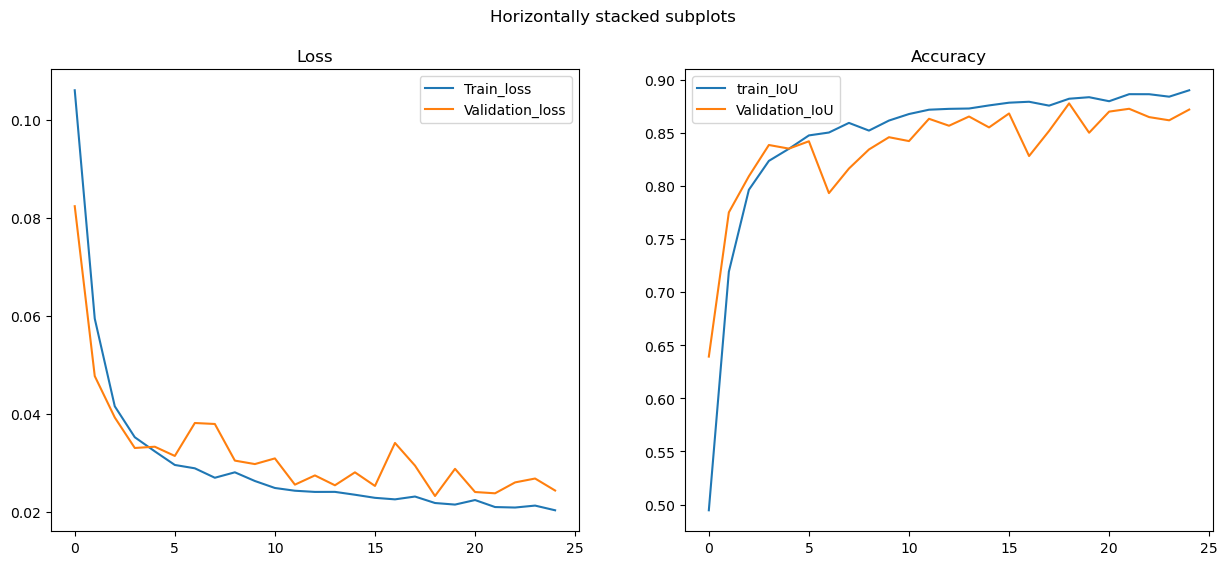

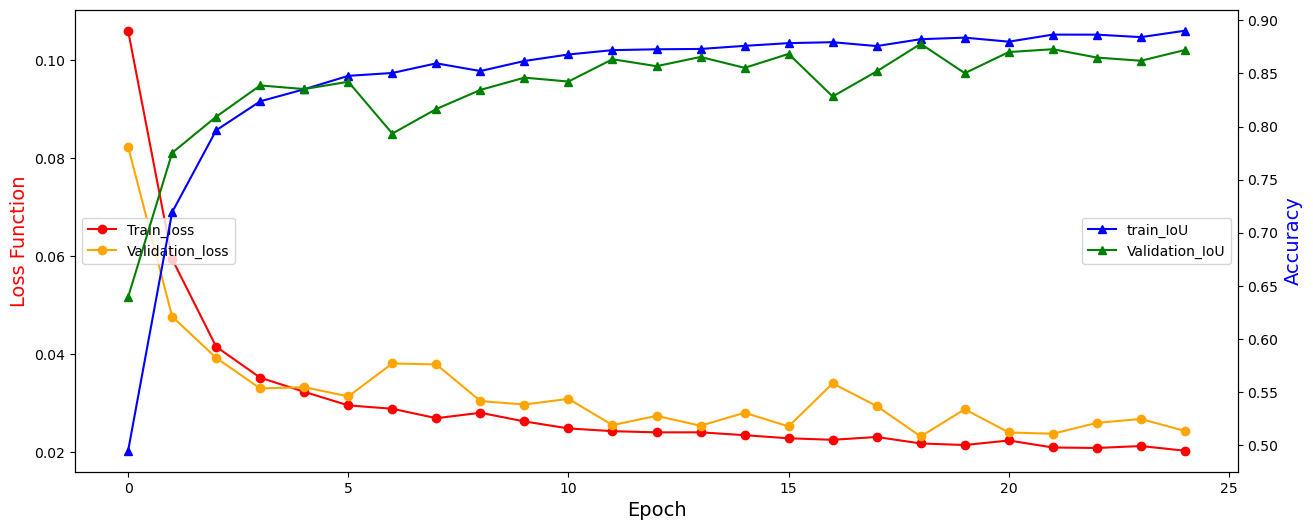

Current time: 16.747 minutes. Time expected till completion: 16.747 minutes

Epoch 26 of 50


100%|██████████| 20/20 [00:01<00:00, 11.18it/s]


train loss:  0.019914507245024044
Val loss:  0.024066966958343983
train IoU:  0.8915651483668221
Val IoU:  0.874435156583786
Current time: 17.414 minutes. Time expected till completion: 16.074 minutes

Epoch 27 of 50


100%|██████████| 20/20 [00:01<00:00, 11.01it/s]


train loss:  0.020145088413523304
Val loss:  0.03022581124678254
train IoU:  0.8905827220943239
Val IoU:  0.8504942685365677
Current time: 18.091 minutes. Time expected till completion: 15.411 minutes

Epoch 28 of 50


100%|██████████| 20/20 [00:01<00:00, 10.81it/s]


train loss:  0.020035885295106304
Val loss:  0.0244287031237036
train IoU:  0.8911421706279119
Val IoU:  0.871348649263382
Current time: 18.771 minutes. Time expected till completion: 14.749 minutes

Epoch 29 of 50


100%|██████████| 20/20 [00:01<00:00, 11.01it/s]


train loss:  0.019432895889298783
Val loss:  0.029067628271877765
train IoU:  0.8933199170562957
Val IoU:  0.8604793012142181
Current time: 19.453 minutes. Time expected till completion: 14.087 minutes

Epoch 30 of 50


100%|██████████| 20/20 [00:01<00:00, 10.90it/s]


train loss:  0.01913598501123488
Val loss:  0.02314844708889723
train IoU:  0.8954234596755769
Val IoU:  0.8780155688524246
Current time: 20.134 minutes. Time expected till completion: 13.423 minutes

Epoch 31 of 50


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


train loss:  0.018656493076640697
Val loss:  0.02418857365846634
train IoU:  0.8972077939245436
Val IoU:  0.876329305768013
Current time: 20.815 minutes. Time expected till completion: 12.758 minutes

Epoch 32 of 50


100%|██████████| 20/20 [00:01<00:00, 10.97it/s]


train loss:  0.022385800764378575
Val loss:  0.025329549983143806
train IoU:  0.8807434992657768
Val IoU:  0.8682808578014374
Current time: 21.495 minutes. Time expected till completion: 12.091 minutes

Epoch 33 of 50


100%|██████████| 20/20 [00:01<00:00, 11.16it/s]


train loss:  0.019500739303314023
Val loss:  0.02802168088965118
train IoU:  0.8930608308977551
Val IoU:  0.8572604030370712
Current time: 22.175 minutes. Time expected till completion: 11.424 minutes

Epoch 34 of 50


100%|██████████| 20/20 [00:01<00:00, 10.93it/s]


train loss:  0.018512359841002357
Val loss:  0.029989834502339364
train IoU:  0.8989291697740555
Val IoU:  0.8604799926280975
Current time: 22.859 minutes. Time expected till completion: 10.757 minutes

Epoch 35 of 50


100%|██████████| 20/20 [00:01<00:00, 11.07it/s]


train loss:  0.018217812437150212
Val loss:  0.0246363949496299
train IoU:  0.8995184732808007
Val IoU:  0.871701928973198
Current time: 23.537 minutes. Time expected till completion: 10.087 minutes

Epoch 36 of 50


100%|██████████| 20/20 [00:01<00:00, 11.04it/s]


train loss:  0.017834144494392804
Val loss:  0.03523237211629748
train IoU:  0.901043395863639
Val IoU:  0.8416226148605347
Current time: 24.219 minutes. Time expected till completion: 9.418 minutes

Epoch 37 of 50


100%|██████████| 20/20 [00:01<00:00, 11.00it/s]


train loss:  0.017677744871212375
Val loss:  0.024792421981692313
train IoU:  0.9023196091254552
Val IoU:  0.8705963730812073
Current time: 24.903 minutes. Time expected till completion: 8.750 minutes

Epoch 38 of 50


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


train loss:  0.017416539896900455
Val loss:  0.02591326222755015
train IoU:  0.9030166526635488
Val IoU:  0.8693262547254562
Current time: 25.585 minutes. Time expected till completion: 8.079 minutes

Epoch 39 of 50


100%|██████████| 20/20 [00:01<00:00, 10.96it/s]


train loss:  0.01681896091128389
Val loss:  0.02441514879465103
train IoU:  0.9062962740659714
Val IoU:  0.8713560223579406
Current time: 26.265 minutes. Time expected till completion: 7.408 minutes

Epoch 40 of 50


100%|██████████| 20/20 [00:01<00:00, 11.19it/s]


train loss:  0.017723429911873406
Val loss:  0.024245207710191608
train IoU:  0.902531952990426
Val IoU:  0.8738427788019181
Current time: 26.946 minutes. Time expected till completion: 6.737 minutes

Epoch 41 of 50


100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


train loss:  0.016730798951660592
Val loss:  0.02543288776651025
train IoU:  0.9069184326463275
Val IoU:  0.8691458135843277
Current time: 27.626 minutes. Time expected till completion: 6.064 minutes

Epoch 42 of 50


100%|██████████| 20/20 [00:01<00:00, 10.96it/s]


train loss:  0.016246736742970017
Val loss:  0.024404079560190438
train IoU:  0.9093033300505744
Val IoU:  0.8740730434656143
Current time: 28.308 minutes. Time expected till completion: 5.392 minutes

Epoch 43 of 50


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


train loss:  0.015821902453899382
Val loss:  0.02846334408968687
train IoU:  0.9113597866561678
Val IoU:  0.8570107519626617
Current time: 28.991 minutes. Time expected till completion: 4.720 minutes

Epoch 44 of 50


100%|██████████| 20/20 [00:01<00:00, 10.84it/s]


train loss:  0.015816976176574828
Val loss:  0.026635666284710167
train IoU:  0.911006396677759
Val IoU:  0.8685482501983642
Current time: 29.673 minutes. Time expected till completion: 4.046 minutes

Epoch 45 of 50


100%|██████████| 20/20 [00:01<00:00, 11.19it/s]


train loss:  0.015450608751012219
Val loss:  0.026818411704152823
train IoU:  0.9132126920753055
Val IoU:  0.8719730228185654
Current time: 30.353 minutes. Time expected till completion: 3.373 minutes

Epoch 46 of 50


100%|██████████| 20/20 [00:01<00:00, 10.94it/s]


train loss:  0.015188371229709851
Val loss:  0.027548925997689367
train IoU:  0.9144326617320379
Val IoU:  0.8698027074337006
Current time: 31.034 minutes. Time expected till completion: 2.699 minutes

Epoch 47 of 50


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


train loss:  0.015452823896581928
Val loss:  0.02976718689315021
train IoU:  0.9127817332744599
Val IoU:  0.8584523856639862
Current time: 31.719 minutes. Time expected till completion: 2.025 minutes

Epoch 48 of 50


100%|██████████| 20/20 [00:01<00:00, 11.06it/s]


train loss:  0.014753520069643856
Val loss:  0.025627528503537177
train IoU:  0.9170706752273772
Val IoU:  0.8746729075908661
Current time: 32.400 minutes. Time expected till completion: 1.350 minutes

Epoch 49 of 50


100%|██████████| 20/20 [00:01<00:00, 11.01it/s]


train loss:  0.0144906060045792
Val loss:  0.025075998343527316
train IoU:  0.9183392935329013
Val IoU:  0.8765778958797454
Current time: 33.087 minutes. Time expected till completion: 0.675 minutes

Epoch 50 of 50


100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


train loss:  0.01459352803002629
Val loss:  0.02666575531475246
train IoU:  0.9179427822430929
Val IoU:  0.8722408503293991
Saving model checkpoint


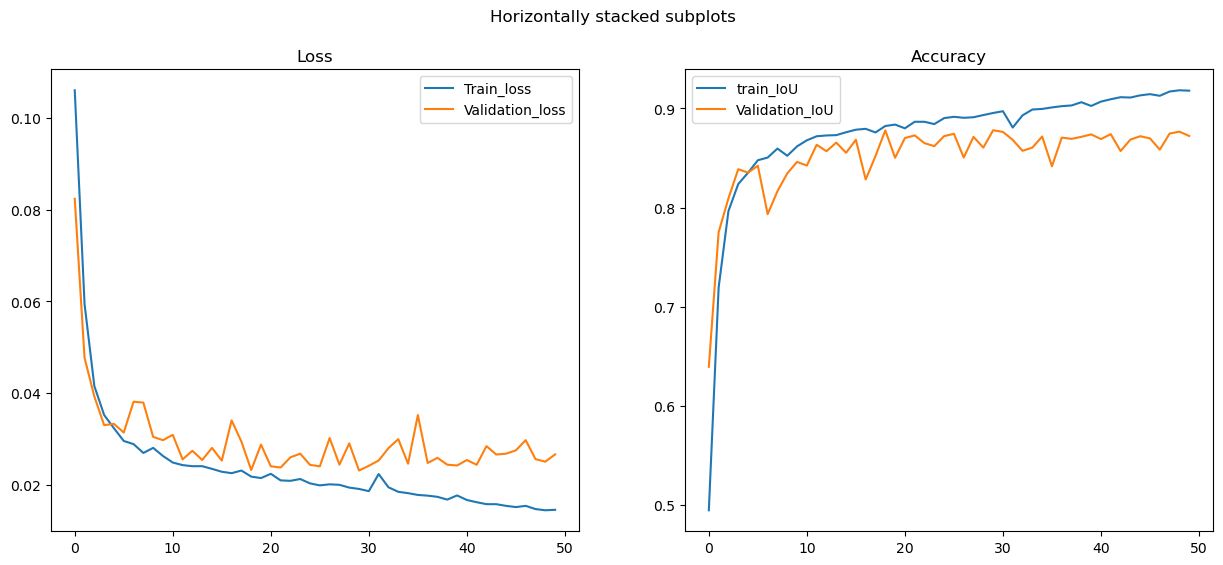

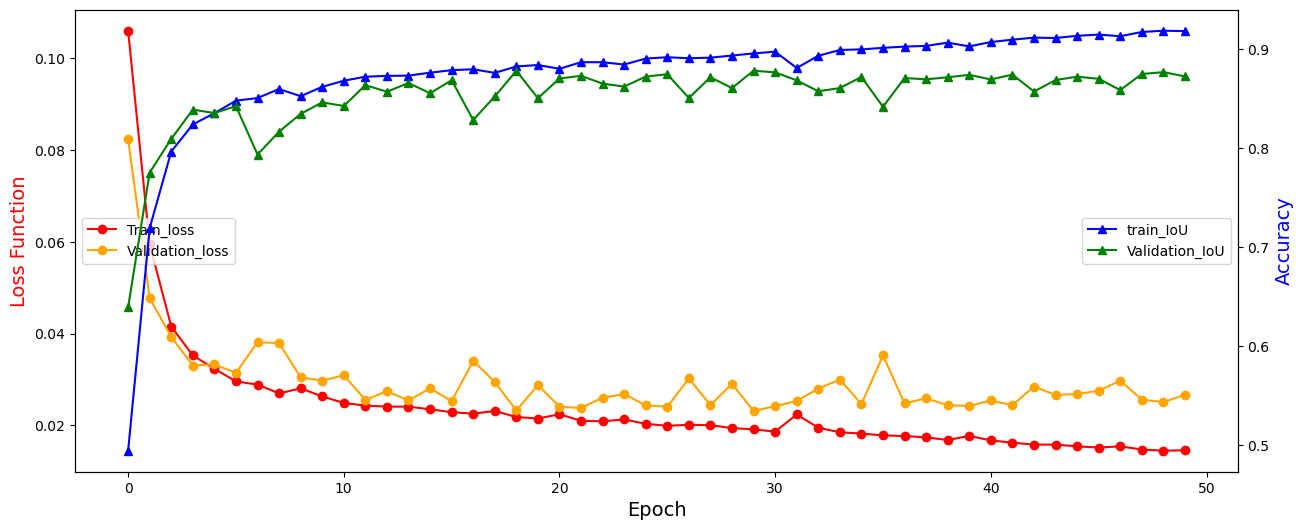

Current time: 33.784 minutes. Time expected till completion: 0.000 minutes
Finished training in: 33.784 minutes


In [16]:

# Main
train_loss, val_loss = [], []
train_IoU, val_IoU = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_IoU = dd["train_IoU"].tolist()
        val_IoU = dd["val_IoU"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    accumulatedIoU=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[2].to(device)# use the gpu
        
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate IoU
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        
        iioouu = calculate_IoU(predictions, labels)
        accumulatedIoU += iioouu.sum().item()
    
    train_epoch_loss = running_loss/len(train_loader.dataset)
    train_epoch_IoU = accumulatedIoU/total
    
    
    modelpy.eval()
    running_loss = 0.0
    total=0
    accumulatedIoU=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            labels = data[2].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, labels)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate IoU
            predictions = torch.argmax(outputs, dim=1)
            total += labels.size(0)

            iioouu = calculate_IoU(predictions, labels)
            accumulatedIoU += iioouu.sum().item()
           
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_IoU = accumulatedIoU/total

    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train IoU: ", train_epoch_IoU)
    print("Val IoU: ", val_epoch_IoU)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_IoU.append(train_epoch_IoU)
    val_IoU.append(val_epoch_IoU)
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_IoU, val_IoU, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_IoU, val_IoU)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

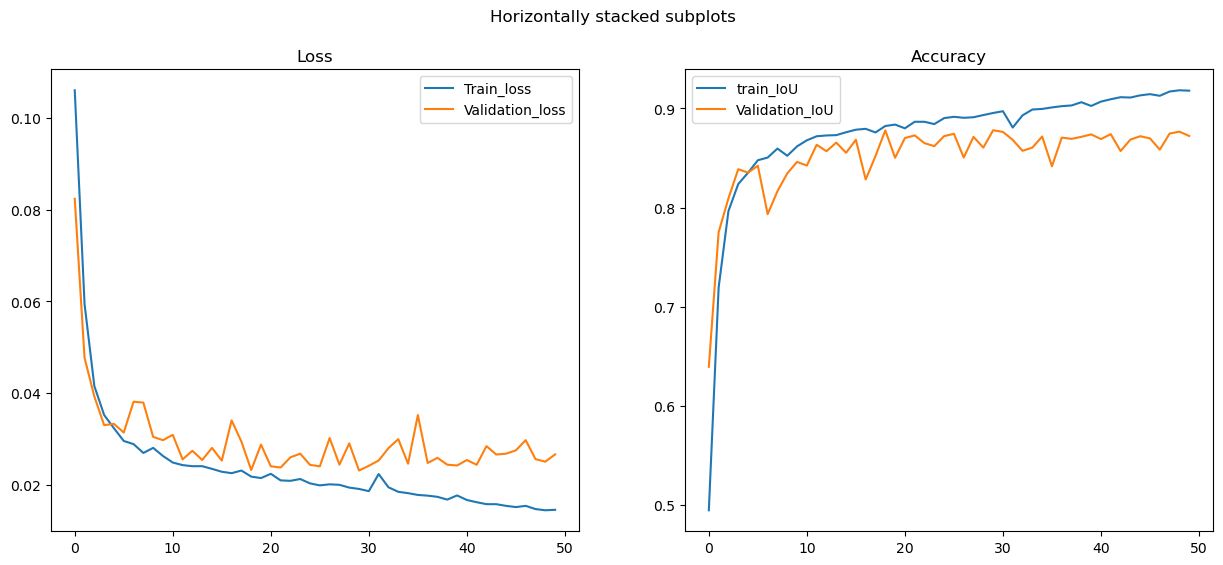

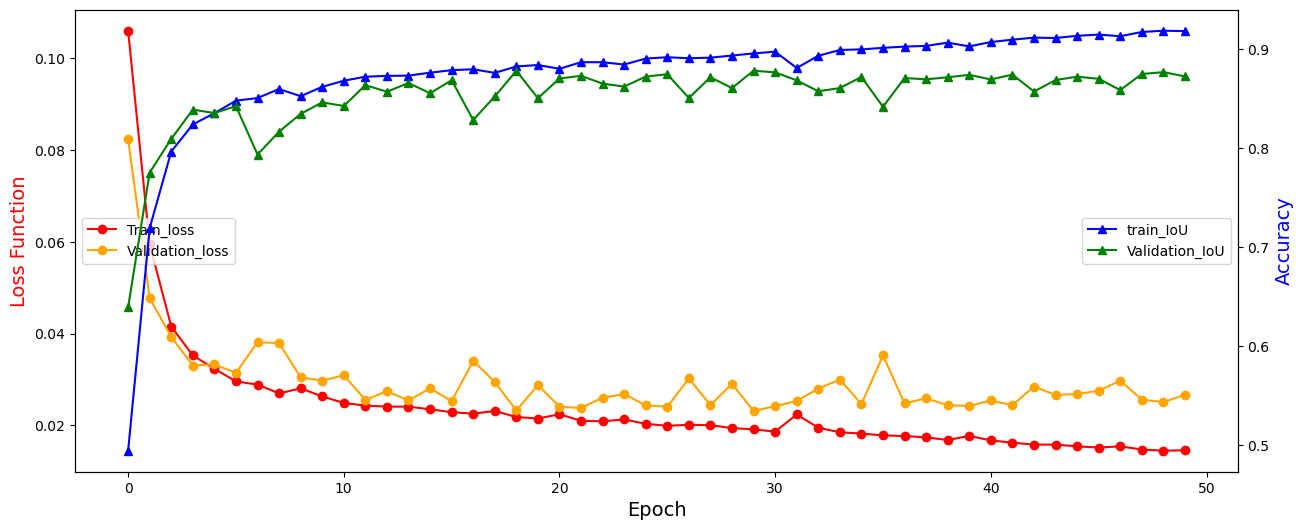

In [17]:
plot_loss_accuracy(train_loss, val_loss, train_IoU, val_IoU)

## Save Model

In [18]:
# Save Model
NAME = "model_1.pt"

torch.save(modelpy.state_dict(), model_checkpoints+NAME)

## Load Model

In [19]:

# Load the model
NAME = "model_1.pt"
modelpy.load_state_dict(torch.load(model_checkpoints+NAME, map_location=device))


<All keys matched successfully>

# 3.Evaluate your model using the test images

In [20]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [21]:
test_data, test_mask, test_labels = import_folder_dataset(root_path = test_data_path, resized_side = img_size)#(1024,1024)


print("Dim of Data: ", test_data.shape)
print("Dim of Mask: ", test_mask.shape)
print("Dim of Lables: ", test_labels.shape)

100%|██████████| 200/200 [00:17<00:00, 11.45it/s]


Dim of Data:  (200, 256, 256, 3)
Dim of Mask:  (200, 256, 256, 3)
Dim of Lables:  (200, 256, 256)


In [22]:
# Create the dataset object
test_Dataset = Data(test_data, test_mask, test_labels, img_transform) 


print("Test len: ",len(test_Dataset))

Test len:  200


In [23]:
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,
    shuffle=False
    )

In [24]:

mean_IoU, mean_dice, image_list, mask_list, predictions_list = make_predictions(loader = test_loader, 
                                                                     model = modelpy, 
                                                                     invTransforamtion = invTrans,
                                                                     device = device)
print(f'Average IoU of the model on the 200 Test dataset instances: {100 * mean_IoU}%')
print(f'Average Dice of the model on the 200 Test dataset instances: {100 * mean_dice}%')

100%|██████████| 200/200 [00:05<00:00, 38.17it/s]

Average IoU of the model on the 200 Test dataset instances: 88.40443260967731%
Average Dice of the model on the 200 Test dataset instances: 93.68672162294388%


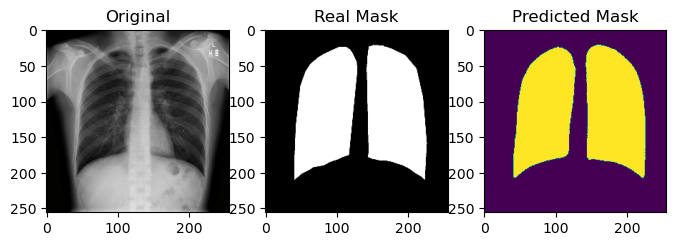

In [25]:
image_to_plot = 10

real_image = image_list[image_to_plot]
real_mask = mask_list[image_to_plot]
pred_mask = predictions_list[image_to_plot]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(8,8))
ax1.imshow(real_image)
ax1.title.set_text("Original")
ax2.imshow(real_mask)
ax2.title.set_text("Real Mask")
ax3.imshow(pred_mask)
ax3.title.set_text("Predicted Mask")
plt.show()

# 4. Your IoU score should be higher than 0.82

In [28]:
print(f'Average IoU of the model on the 200 Test dataset instances: {100 * mean_IoU}%')

Average IoU of the model on the 200 Test dataset instances: 88.40443260967731%


In [27]:
print(f'Average Dice of the model on the 200 Test dataset instances: {100 * mean_dice}%')

Average Dice of the model on the 200 Test dataset instances: 93.68672162294388%


# 5. Write a two-page report using LaTex and upload your paper to ResearchGate or Arxiv. 
